## Find box office hits

My task is to build a model of box office revenue for movies from The Movie Database. The results of this model would feed into a decision-making algorithm that a big movie theater chain uses to select which movies to run. The output of this supervised regression is critical to optimizing ticket revenue for your employer.

Current estimations are currently done mainly by intuition and checking buzz.

Kernels:
* https://www.kaggle.com/zero92/tmdb-prediction
* https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation

Blogs:
* https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
* https://towardsdatascience.com/columntransformer-meets-natural-language-processing-da1f116dd69f
* https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
* https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
* https://scikit-learn.org/dev/modules/compose.html
* https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

## Notes on this exercise...

I'm using this primarily as an opportunity to practice building data prep functions, transformers, and Sklearn Pipelines. I'll be spending most of my time on the workflow, rather than focusing on model performance. 

### Check assumptions

I'm going to build a model off of these movies titles to build a box office forecast for future movies. 

* Does this need to be a regression task?
* Should it be online? Or is it okay that it's offline?
* How expansive is this data? Is it enough to make statements about other movies, or should more data be collected?
* Are these titles are representative of the full gamut of movies?
* Are movie-going patterns the same today that they were 10 years ago? Will be the same that they are 10 years later?

I'm going to treat this as a continuous regression task. It's possible to run this as a classification task or interval regression task as well.

I'm going to run it offline and in batch since the data isn't so big; if I were to deploy this project I would set it up as an online learning problem. There probably isn't enough data to make broader generalizations. And if we were to deploy, weighting movies that are more recent is a good idea as media consumption has changed significantly in just the past five years.

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, OrderedDict
from ast import literal_eval
from itertools import chain

## 1. Get the data

This data comes from a [Kaggle competition](https://www.kaggle.com/c/tmdb-box-office-prediction/data) hosted by TMDB.

In [2]:
## renamed the training data to TMDB_movie_data.csv, and stored it in a local folder called Data
movies = pd.read_csv("../Data/TMDB_movie_data.csv")
movies.shape

(3000, 23)

There's only 3000 samples of training data, which seems a bit scarce.

In [3]:
movies.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import datetime

In [5]:
movies[['belongs_to_collection','genres','production_companies',
        'production_countries','spoken_languages',
        'Keywords','cast','crew']].head()

,belongs_to_collection,genres,production_companies,production_countries,spoken_languages,Keywords,cast,crew
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...","[{'id': 35, 'name': 'Comedy'}]","[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,"[{'id': 107674, 'name': 'The Princess Diaries ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,NaN,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,NaN,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]","[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]","[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de..."


These columns store data as lists of dictionaries. Time to extract info form these guys.

`popularity` is an attribute that probably wouldn't normally be available prior to release, but I'll keep it for now.

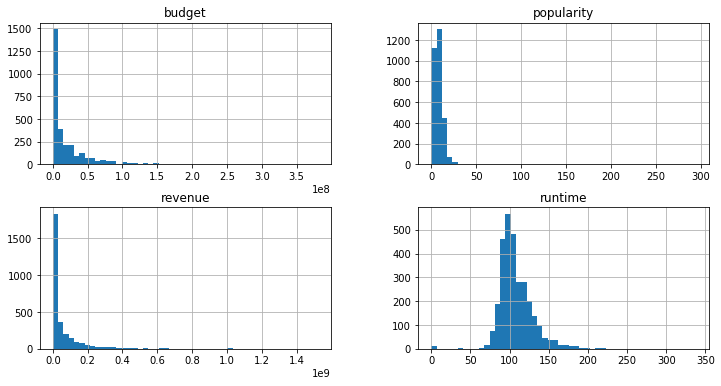

In [6]:
import matplotlib.pyplot as plt
movies[['budget','runtime','revenue','popularity']].hist(bins=50,figsize=(12,6));
plt.show();

It seems like budget generally outpaces revenue, since it's on a larger scale. Both budget and revenue are right-tailed.

Average movie length is around 100 minutes.

## 2. Split the data

Budget is one of the most important predictors of box office gross. To make sure my training and testing datasets are representative of budget distribution, I can use [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) -- sampling with respect to groupings (strata) -- to achieve this. This isn't an example of data leakage because I'm creating strata based off of outside research, rather than what I'm observing in the full dataset.

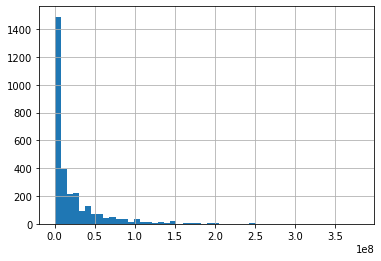

In [7]:
movies['budget'].hist(bins=50);

The buckets that I'm using are based off of the writer's guild budget agreements and a bit of tweaking on my part. I'll use low budget (< \\$30m), medium budget (between \\$30 and \\$80m), and high budget (> \\$80m)  as the strata in a temporary feature called `budget_cat`. 

In [8]:
movies['budget_cat'] = pd.cut(movies['budget'],[0,30000000,80000000,5000000000],labels=['low','medium','high'])

# make NaN cateogry, fill it in
movies['budget_cat'] = movies['budget_cat'].cat.add_categories('unknown')
movies['budget_cat'].fillna('unknown',inplace=True)

movies['budget_cat'].value_counts()

low        1505
unknown     812
medium      487
high        196
Name: budget_cat, dtype: int64

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=.2,random_state=14)

for train_index, test_index in split.split(movies, movies['budget_cat']):
    train = movies.loc[train_index]
    test = movies.loc[test_index]

print('Original data budget proportions:', movies['budget_cat'].value_counts()/len(movies),'',
      'Stratified training set budget proportions:',train['budget_cat'].value_counts()/len(train),
      sep = '\n'
     )

Original data budget proportions:
low        0.501667
unknown    0.270667
medium     0.162333
high       0.065333
Name: budget_cat, dtype: float64

Stratified training set budget proportions:
low        0.501667
unknown    0.270417
medium     0.162500
high       0.065417
Name: budget_cat, dtype: float64


Stratification successful. Next, I remove the temporary `budget_cat` attribute.

In [10]:
for dataset in [train,test]:
    dataset.drop(['budget_cat'],axis=1,inplace=True)

## 3. Brief data exploration

Look for data structure, null values, distributions, outliers, and complexity of categorical variables.

Note: only visualize on the training data.

In [11]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

#### What's the structure of the data?

Get a sense of the amount of cleaning necessary.

In [12]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2545,2546,NaN,45000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.patriotsdayfilm.com/,tt4572514,en,Patriots Day,An account of Boston Police Commissioner Ed Da...,14.547939,...,12/12/16,133.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,The inside story of the world's greatest manhunt.,Patriots Day,"[{'id': 1680, 'name': 'boston'}, {'id': 1700, ...","[{'cast_id': 4, 'character': 'Sgt. Tommy Saund...","[{'credit_id': '587cad3bc3a3684a9e01776f', 'de...",50548152
2415,2416,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0106387,en,Benny & Joon,A mentally ill young woman finds her love in a...,10.597116,...,4/16/93,98.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A romance on the brink of reality.,Benny & Joon,"[{'id': 1155, 'name': 'brother sister relation...","[{'cast_id': 2, 'character': 'Sam', 'credit_id...","[{'credit_id': '52fe43adc3a36847f8066f63', 'de...",23202734
1919,1920,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,tt0458367,en,Right at Your Door,"A dirty bomb goes off in Los Angeles, jamming ...",4.010441,...,1/23/06,96.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Right at Your Door,"[{'id': 4458, 'name': 'post-apocalyptic'}]","[{'cast_id': 3, 'character': 'Lexi', 'credit_i...","[{'credit_id': '52fe46709251416c75078597', 'de...",2043704
1462,1463,NaN,8000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://focusfeatures.com/its_kind_of_a_funny_s...,tt0804497,en,It's Kind of a Funny Story,A clinically depressed teenager gets a new sta...,8.172013,...,7/6/10,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sometimes what's in your head isn't as crazy a...,It's Kind of a Funny Story,"[{'id': 236, 'name': 'suicide'}, {'id': 894, '...","[{'cast_id': 11, 'character': 'Craig Gilner', ...","[{'credit_id': '567f355792514132db008f84', 'de...",6491240
220,221,NaN,12000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",http://www.cityoflifeanddeath.co.uk/,tt1124052,zh,南京!南京!,"City of Life and Death takes place in 1937, du...",7.216103,...,4/22/09,132.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,City of Life and Death,"[{'id': 1327, 'name': 'war crimes'}, {'id': 15...","[{'cast_id': 1, 'character': 'Lu Jianxiong', '...","[{'credit_id': '53afe79a0e0a265975005fda', 'de...",10652498


`genres`, `spoken languages`, `keywords`, `cast`, and `crew` are stored as lists of dictionaries. That will be thorny to parse, but there's good information in there.

It looks like there will be some NLP for title and overview.

Popularity seems like slight cheating since it's probably post-release, but I'll keep it lol.

#### How many missing values?

In [13]:
train.isnull().sum().sort_values(ascending=False)

belongs_to_collection    1939
homepage                 1637
tagline                   478
Keywords                  228
production_companies      129
production_countries       46
spoken_languages           18
crew                       10
cast                        9
overview                    8
genres                      4
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

A lot of of missing values for `belongs_to_collection` and `homepage`. Hopefully they'll still be useful. For the most part, information looks pretty good.

In [14]:
train['original_language'].value_counts()

en    2067
fr      58
hi      37
ru      36
es      36
ja      30
it      18
cn      16
ko      15
de      14
zh      13
ta      12
sv       8
fa       5
ro       4
nl       4
pt       3
da       3
hu       2
tr       2
ml       2
pl       2
fi       2
te       2
no       1
vi       1
he       1
mr       1
nb       1
cs       1
ur       1
id       1
ar       1
Name: original_language, dtype: int64

Most of these movies are in English, followed by French, Hindi, and other languages. There's too many levels here, so I'll want bin many of these language categories as "other".

#### Check revenue distribution

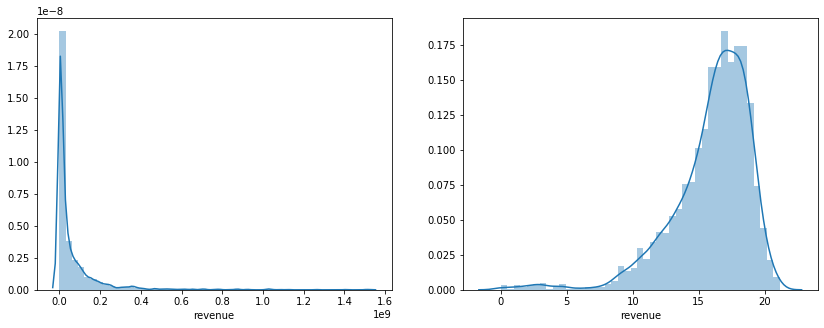

In [15]:
fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=False)

sns.distplot(train['revenue'],ax=ax[0]);
sns.distplot(np.log(train['revenue']),ax=ax[1]);

Right-tailed. Use median to get "average" movie revenue.

#### Correlations

In [16]:
corr_matrix = train.drop('id',axis=1).corr()
corr_matrix['revenue'].sort_values(ascending=False)

revenue       1.000000
budget        0.743399
popularity    0.469439
runtime       0.195318
Name: revenue, dtype: float64

Budget and runtime are both very strongly correlated with revenue. 

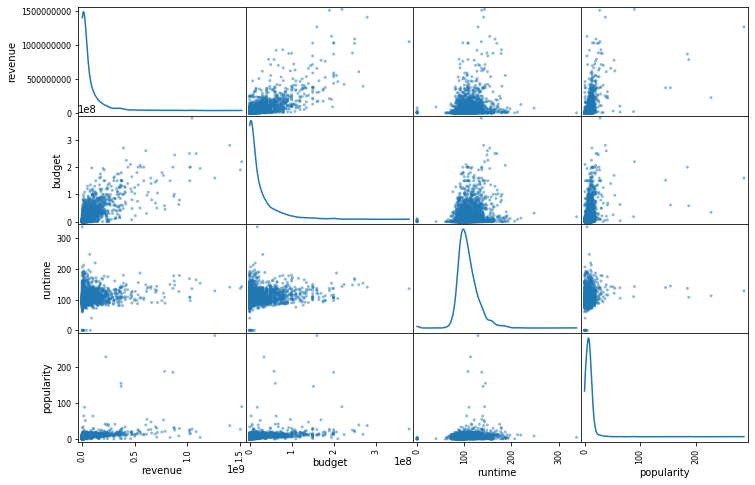

In [17]:
from pandas.plotting import scatter_matrix

attributes = ['revenue','budget','runtime','popularity']
scatter_matrix(train[attributes],diagonal='kde',figsize=(12,8));

#### Runtime: some movies have a runtime of 0

In [18]:
train.loc[train['runtime']==0,['title','runtime']]

,title,runtime
2865,Tutto tutto niente niente,0.0
2498,Hooked on the Game 2. The Next Level,0.0
1874,Missing,0.0
591,А поутру они проснулись,0.0
2645,My Old Classmate,0.0
2785,Revelation,0.0
1255,"Cry, Onion!",0.0
1541,All at Once,0.0
390,The Worst Christmas of My Life,0.0
2150,Mechenosets,0.0


For some reason or another, this data is just missing. For example, *Tutto tutto niente niente* is 96 min and *Cry, Onion* is 92 min. These can be fixed with a few quick Google searches.

In [19]:
train.loc[train['runtime']==0,'runtime'] = [96,108,122,90,98,111,92,112,86,108,93]

#### Revenue: check movies that have extremely low or no revenue

In [20]:
movies.loc[movies['revenue'] < 100, ['title','revenue']].head()

,title,revenue
150,Windwalker,18
269,Glass: A Portrait of Philip in Twelve Parts,20
280,Bats,10
312,The Cookout,12
334,Saamy,3


*Windwalker* grossed \$18m; *Glass* grossed \$20,018; *Bats* grossed \$10m, *The Cookout* grossed \$12m. 

There are 39 movies in this database with revenues under 100. I'm willing to bet most of them have incorrect recorded revenues. In fact, I'd be willing to bet that even most movies under \$1000 in revenue probably have incorrect labels. What I can do is test different datasets. 

I'll use a pipeline to test datasets where I ignore rows under \$100, \$500, and \$1000 in revenue, and decide which preparation method to use through cross-validation.

#### Popularity and revenue

There's several very popular movies that seem to not generate that much revenue. Would be helpful to explore these.

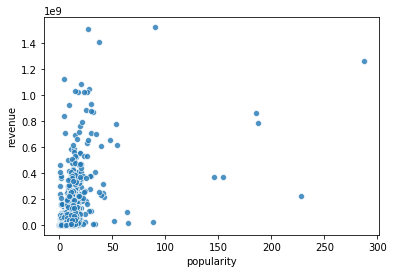

In [21]:
sns.scatterplot('popularity','revenue', data = train, alpha = .8);

In [22]:
train['revenue_to_budget'] = train['revenue']/(train['budget']+1)

train[['original_title',
       'popularity',
       'revenue_to_budget',
       'revenue',
       'budget']].sort_values('popularity',ascending=False).head(15)

train.drop('revenue_to_budget',axis=1,inplace=True)

Interestingly, Baby Driver did really well for its budget, making several multiples of its originally money. It seems as though popularity alone doesn't always serve as a great barometer for revenue. For example, The Circle, Fight Club, and The Shawshank Redemption didn't do super well. But maybe online popularity could act as a lever, affecting the multiple at which a movie earns back its budget.

I should probably figure out how popularity is determined. Next question: why do moderately popular movies end up making a lot of money?

In [23]:
train.loc[train['popularity']<100,
          ['original_title',
           'popularity',
           'revenue_to_budget',
           'revenue',
           'budget']].sort_values('revenue',ascending=False).head(10)

/Users/collindching/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,original_title,popularity,revenue_to_budget,revenue,budget
1126,The Avengers,89.887648,NaN,1519557910,220000000
1761,Furious 7,27.275687,NaN,1506249360,190000000
2770,Avengers: Age of Ultron,37.379420,NaN,1405403694,280000000
2322,Transformers: Dark of the Moon,4.503505,NaN,1123746996,195000000
906,The Dark Knight Rises,20.582580,NaN,1084939099,250000000
2135,Pirates of the Caribbean: On Stranger Tides,27.887720,NaN,1045713802,380000000
2562,Finding Dory,14.477677,NaN,1028570889,200000000
881,Alice in Wonderland,17.285093,NaN,1025491110,200000000
734,Zootopia,26.024868,NaN,1023784195,150000000
2532,The Hobbit: An Unexpected Journey,23.253089,NaN,1021103568,250000000


The movies that crushed despite pretty moderate popularity all benefited from extremely large budgets. Maybe TMDB popularity isn't all that important.

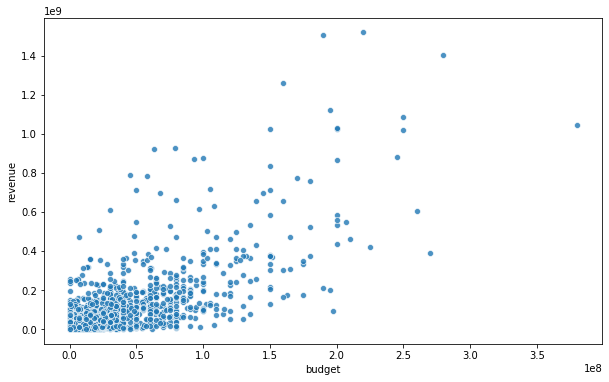

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='budget',y='revenue',data=train,alpha=.8);

In [25]:
train[['original_title','budget','revenue']].sort_values('budget',ascending=False).head(10)

,original_title,budget,revenue
2135,Pirates of the Caribbean: On Stranger Tides,380000000,1045713802
2770,Avengers: Age of Ultron,280000000,1405403694
1425,Superman Returns,270000000,391081192
1630,Transformers: The Last Knight,260000000,604942143
2532,The Hobbit: An Unexpected Journey,250000000,1021103568
906,The Dark Knight Rises,250000000,1084939099
2737,Spectre,245000000,880674609
1249,The Chronicles of Narnia: Prince Caspian,225000000,419651413
1126,The Avengers,220000000,1519557910
1880,X-Men: The Last Stand,210000000,459359555


A lot of the points are scattered towards the low end in terms of budget and revenue. There's a few movies that had really high budgets, but didn't end up generating too much revenue.

## 4. Clean data and explore further

In [26]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2545,2546,NaN,45000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.patriotsdayfilm.com/,tt4572514,en,Patriots Day,An account of Boston Police Commissioner Ed Da...,14.547939,...,12/12/16,133.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,The inside story of the world's greatest manhunt.,Patriots Day,"[{'id': 1680, 'name': 'boston'}, {'id': 1700, ...","[{'cast_id': 4, 'character': 'Sgt. Tommy Saund...","[{'credit_id': '587cad3bc3a3684a9e01776f', 'de...",50548152
2415,2416,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0106387,en,Benny & Joon,A mentally ill young woman finds her love in a...,10.597116,...,4/16/93,98.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A romance on the brink of reality.,Benny & Joon,"[{'id': 1155, 'name': 'brother sister relation...","[{'cast_id': 2, 'character': 'Sam', 'credit_id...","[{'credit_id': '52fe43adc3a36847f8066f63', 'de...",23202734
1919,1920,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,tt0458367,en,Right at Your Door,"A dirty bomb goes off in Los Angeles, jamming ...",4.010441,...,1/23/06,96.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Right at Your Door,"[{'id': 4458, 'name': 'post-apocalyptic'}]","[{'cast_id': 3, 'character': 'Lexi', 'credit_i...","[{'credit_id': '52fe46709251416c75078597', 'de...",2043704
1462,1463,NaN,8000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://focusfeatures.com/its_kind_of_a_funny_s...,tt0804497,en,It's Kind of a Funny Story,A clinically depressed teenager gets a new sta...,8.172013,...,7/6/10,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sometimes what's in your head isn't as crazy a...,It's Kind of a Funny Story,"[{'id': 236, 'name': 'suicide'}, {'id': 894, '...","[{'cast_id': 11, 'character': 'Craig Gilner', ...","[{'credit_id': '567f355792514132db008f84', 'de...",6491240
220,221,NaN,12000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",http://www.cityoflifeanddeath.co.uk/,tt1124052,zh,南京!南京!,"City of Life and Death takes place in 1937, du...",7.216103,...,4/22/09,132.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,City of Life and Death,"[{'id': 1327, 'name': 'war crimes'}, {'id': 15...","[{'cast_id': 1, 'character': 'Lu Jianxiong', '...","[{'credit_id': '53afe79a0e0a265975005fda', 'de...",10652498


In [27]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

##  `release_date`

* http://strftime.org/
* https://kite.com/python/docs/pandas.core.indexes.accessors.DatetimeProperties

In [28]:
print("Original date format:",train['release_date'][0])
train['release_date'] = pd.to_datetime(train['release_date'],format="%m/%d/%y")
test['release_date'] = pd.to_datetime(test['release_date'],format="%m/%d/%y")
print("New date format:",train['release_date'][0])

Original date format: 2/20/15
New date format: 2015-02-20 00:00:00


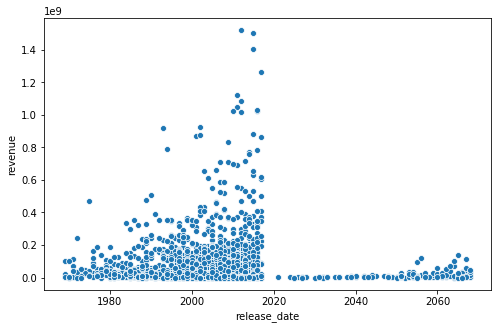

In [29]:
import seaborn as sns

plt.figure(figsize=(8,5));
sns.scatterplot(train['release_date'].dt.year,train['revenue']);

What the heck is happening here!! 

It turns out `to_datetime` converts all dates where year is 00 - 68 gets mapped to 2000 - 2068 and everything 69 - 99 gets mapped to 1969 - 1999. This is due to the datetime library's usage of POSIX/ISO C standard. ([Read more](https://stackoverflow.com/questions/37766353/pandas-to-datetime-parsing-wrong-year)).

All years past 2019 are actually meant to be in the 1900s. I'll fix this by subtracting 100 years from `release_date`.

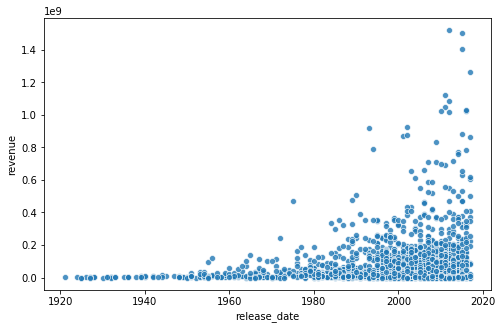

In [30]:
# subtracts years for dates that haven't yet occurred
def subtract_years(dates, n_years, last_year = 2018):
    dates_copy = dates.copy()
    dates_copy[dates_copy.dt.year > last_year] = dates_copy[dates_copy.dt.year > 2019] \
                                                - datetime.timedelta(days = n_years*365.25)
    
    return dates_copy

# subtract 100 years
train['release_date'] = subtract_years(train['release_date'],100)
test['release_date'] = subtract_years(test['release_date'],100)

plt.figure(figsize=(8,5));
sns.scatterplot(train['release_date'].dt.year,train['revenue'],alpha=.8);

Movie revenue seems to be increasing every year! Track the average each year? 

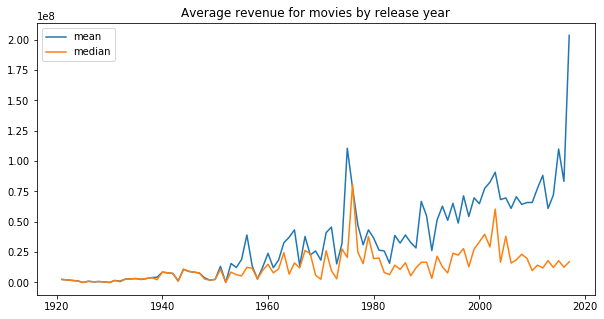

In [31]:
train['release_year'] = train['release_date'].dt.year
test['release_year'] = test['release_date'].dt.year

plt.figure(figsize=(10,5));
plt.plot(train[['release_year','revenue']].groupby('release_year').agg(['mean']));
plt.plot(train[['release_year','revenue']].groupby('release_year').agg(['median']));
plt.legend(['mean','median']);
plt.title('Average revenue for movies by release year');

While mean movie revenue increases each year (due to some probably extremely high budget films), the median revenue is relatively stable.

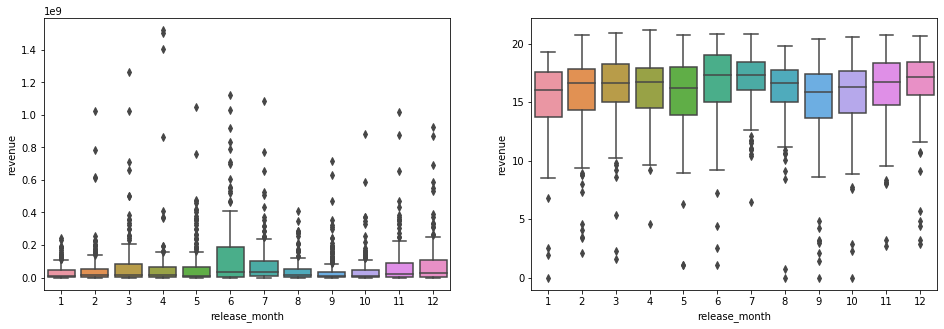

In [32]:
train['release_month'] = train['release_date'].dt.month
test['release_month'] = test['release_date'].dt.month

fig, ax = plt.subplots(1,2,figsize=(16,5),sharey=False)
sns.boxplot(train['release_month'],train['revenue'],ax=ax[0]);
sns.boxplot(train['release_month'],np.log(train['revenue']),ax=ax[1]);

June is a hot month for movies. So is December. I think I'll turn each month into a separate dummy variable. Seasons will be helpful to look at.

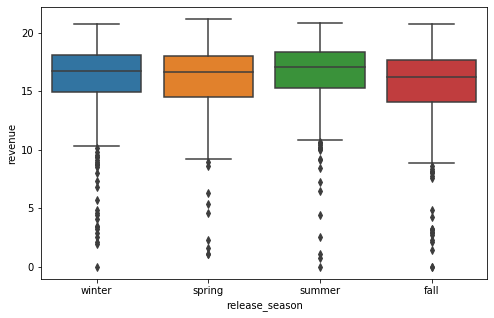

In [33]:
def get_season(dates):
    season = [1,1,2,2,2,3,3,3,4,4,4,1]
    
    season_map = {
        1:'winter',
        2:'spring',
        3:'summer',
        4:'fall'
    }
    
    return dates.dt.month.apply(lambda x: season_map[season[x - 1]])

train['release_season'] = get_season(train['release_date'])
test['release_season'] = get_season(test['release_date'])

plt.figure(figsize=(8,5));
sns.boxplot(train['release_season'],np.log(train['revenue']));

Movies appear to perform slightly better in summer than they do in the other months. Movies in fall also seem to perform worse. Based on this, I think I should make summer and fall into dummy columns (feature engineering step). I probably won't use the other seasons.

Summary of `release_date` findings: 

* Make dummies from season
* Make dummies of summer and fall

## `belongs_to_collection`

In [34]:
def get_vals(dict_list, key, fill='unknown'):
    vals = []

    for d in dict_list:
        val = d[key]

        if type(val) is str:
            vals.append(val.lower())
        else:
            vals.append(val)

    return vals 
   
def extract_vals(column, key, fill = 'unknown'):
    column_copy = column.copy()
    
    if fill == 0:
        column_copy = column_copy.fillna(f"[{{'{key}':0}}]")
    else:
        column_copy = column_copy.fillna(f"[{{'{key}':'{fill}'}}]")
    
    try: 
        column_copy_vals = column_copy.apply(literal_eval).apply(lambda x: get_vals(x,key))
        return column_copy_vals
    ## if already extracted, don't extract again
    except ValueError:
        return column

def get_freq(column_vals, n_top = -1):
    column_vals_flat = list(chain(*column_vals))
    counter = Counter(column_vals_flat)
    
    if n_top == -1:
        return sorted(counter.items(), key = lambda item: -item[1])
    else:
        return sorted(counter.items(), key = lambda item: -item[1])[:n_top]

    
get_freq(extract_vals(train['belongs_to_collection'],'name'))

[('unknown', 1939),
 ('james bond collection', 14),
 ('pokémon collection', 5),
 ('friday the 13th collection', 5),
 ('the pink panther (original) collection', 4),
 ('rambo collection', 4),
 ('the fast and the furious collection', 4),
 ('transformers collection', 4),
 ('halloween collection', 3),
 ("child's play collection", 3),
 ('cars collection', 3),
 ('ice age collection', 3),
 ('the jaws collection', 3),
 ('[rec] collection', 3),
 ('rush hour collection', 3),
 ('resident evil collection', 3),
 ('missing in action collection', 3),
 ('qatsi collection', 2),
 ('diary of a wimpy kid collection', 2),
 ('dracula (hammer series)', 2),
 ('what the bleep! collection', 2),
 ('v/h/s collection', 2),
 ("national lampoon's vacation collection", 2),
 ('the expendables collection', 2),
 ('ted collection', 2),
 ('police academy collection', 2),
 ('pirates of the caribbean collection', 2),
 ('would i lie to you? collection', 2),
 ('asterix and obelix collection', 2),
 ('mexico trilogy', 2),
 ('per

Too many levels. But there's predictive value in whether or not a movie is part of a series.

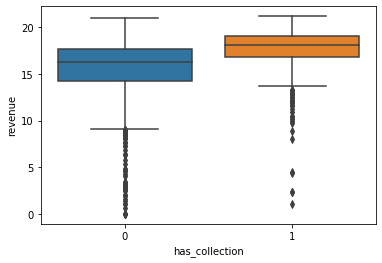

In [35]:
train['has_collection'] = [1 if 'unknown' not in x else 0 for x in extract_vals(train['belongs_to_collection'],'name')]
test['has_collection'] = [1 if 'unknown' not in x else 0  for x in extract_vals(test['belongs_to_collection'],'name')]

sns.boxplot(train['has_collection'], np.log(train['revenue']));

## `homepage`

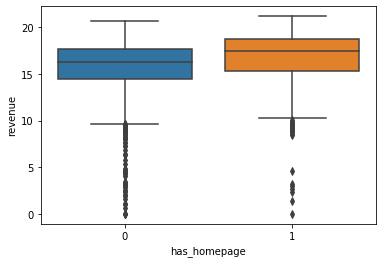

In [36]:
train['has_homepage'] = np.where(train['homepage'].notnull(), 1, 0)
test['has_homepage'] = np.where(test['homepage'].notnull(), 1, 0)

sns.boxplot(train['has_homepage'], np.log(train['revenue']));

## `original_language`

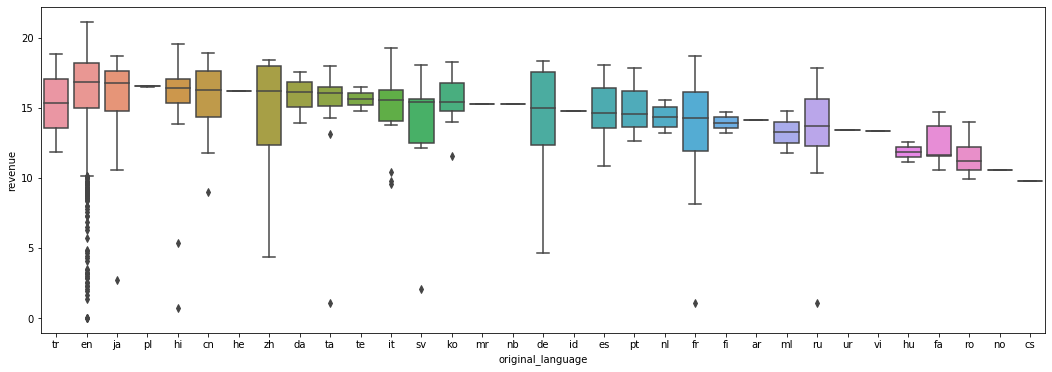

In [37]:
plt.figure(figsize=(18,6))

order = list(train[['original_language','revenue']].groupby('original_language').agg('median').sort_values('revenue',ascending=False)['revenue'].index)
sns.boxplot('original_language', np.log(train['revenue']), data=train, order = order);

In [38]:
sorted(Counter(train['original_language']).items(), key = lambda item: -item[1])

[('en', 2067),
 ('fr', 58),
 ('hi', 37),
 ('ru', 36),
 ('es', 36),
 ('ja', 30),
 ('it', 18),
 ('cn', 16),
 ('ko', 15),
 ('de', 14),
 ('zh', 13),
 ('ta', 12),
 ('sv', 8),
 ('fa', 5),
 ('ro', 4),
 ('nl', 4),
 ('da', 3),
 ('pt', 3),
 ('ml', 2),
 ('tr', 2),
 ('hu', 2),
 ('fi', 2),
 ('pl', 2),
 ('te', 2),
 ('cs', 1),
 ('no', 1),
 ('vi', 1),
 ('ar', 1),
 ('id', 1),
 ('mr', 1),
 ('nb', 1),
 ('he', 1),
 ('ur', 1)]

Going to only keep the top 5 languages. The rest will be set to 'other'.

In [39]:
top_languages = ['en','fr','hi','ru','es']

train.loc[[x not in top_languages for x in train['original_language']], 'original_language'] = 'other'
test.loc[[x not in top_languages for x in test['original_language']], 'original_language'] = 'other'

## `tagline` (to do)

In [40]:
train['tagline'].head()

2545    The inside story of the world's greatest manhunt.
2415                   A romance on the brink of reality.
1919                                                  NaN
1462    Sometimes what's in your head isn't as crazy a...
220                                                   NaN
Name: tagline, dtype: object

## `genres`

The `genres` field consists of a list of dictionaries, where each dictionary represents a single genre. This list is represented as a string. In order to extract the appropriate information, I'll have to convert the string to a list, then extract the genre from each element. I'll define a helper function, `get_vals()` to extract the genre from each dictionary.

In [41]:
train['genres'] = extract_vals(train['genres'],'name')
test['genres'] = extract_vals(test['genres'],'name')

get_freq(train['genres'],15)

[('drama', 1212),
 ('comedy', 824),
 ('thriller', 631),
 ('action', 584),
 ('romance', 473),
 ('crime', 388),
 ('adventure', 352),
 ('horror', 239),
 ('science fiction', 230),
 ('family', 217),
 ('fantasy', 178),
 ('mystery', 173),
 ('animation', 120),
 ('history', 109),
 ('war', 88)]

About half of the 2400 movies in the training set are drama. The 12th biggest genre, mystery, encompasses only about 7.2% of movies. I'll keep the top 15 for now.

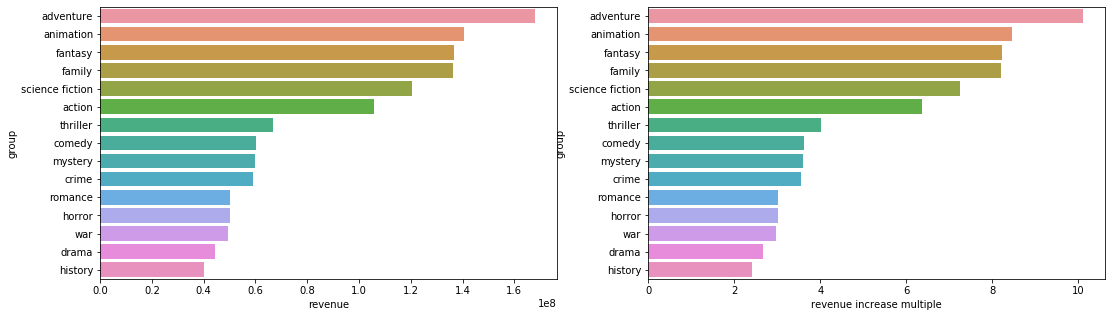

In [42]:
def rev_summary(df, col_name, top_n, sort = True):
    return_df = pd.DataFrame(columns=['group','revenue'])
    return_df['group'] = [x[0] for x in get_freq(df[col_name], top_n)]
    
    for i, g in enumerate(return_df['group']):
        has_g = [(g in x) for x in df[col_name]]
        av_revenue = np.mean(df.loc[has_g,'revenue'])
        return_df['revenue'].iloc[i] = av_revenue
        
    if sort:
        return_df.sort_values('revenue',ascending=False,inplace=True)
    
    return return_df

fig, ax = plt.subplots(1,2,figsize=(18,5),sharey=False)
genre_sum = rev_summary(train, 'genres', 15)
av_revenue = np.median(train['revenue'])

sns.barplot('revenue','group', data = genre_sum, ax = ax[0]);
sns.barplot(genre_sum['revenue']/av_revenue, genre_sum['group'], ax = ax[1])
ax[1].set_xlabel('revenue increase multiple');

`revenue increase multiple` indicates how well the genre performs compared to median movie revenue for the entire dataset. 

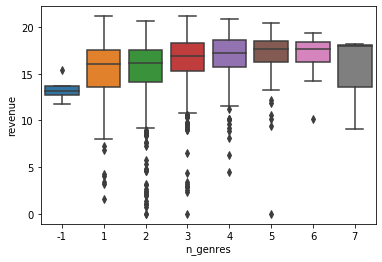

In [43]:
def count_items(column):
    # if unknown, return 0
    return [-1 if 'unknown' in x else len(x) for x in column]

train['n_genres'] = count_items(train['genres'])
test['n_genres'] = count_items(test['genres'])

sns.boxplot('n_genres',np.log(train['revenue']),data=train);

I should make a dummy out of -1.

In [44]:
train.loc[train['n_genres']==7,['id','revenue']]

,id,revenue
1755,1756,9216
2177,2178,61141030
1080,1081,80936232


In [45]:
train.loc[1755,'genres'] = ['unknown']
train.loc[1755,'n_genres'] = -1

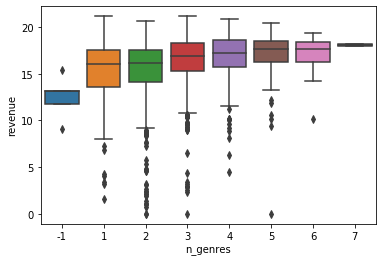

In [46]:
sns.boxplot('n_genres',np.log(train['revenue']),data=train);

## `production_companies`

In [47]:
train['production_companies'] = extract_vals(train['production_companies'],'name')
test['production_companies'] = extract_vals(test['production_companies'],'name')
get_freq(train['production_companies'])

[('warner bros.', 160),
 ('universal pictures', 153),
 ('unknown', 129),
 ('paramount pictures', 123),
 ('twentieth century fox film corporation', 116),
 ('columbia pictures', 74),
 ('metro-goldwyn-mayer (mgm)', 66),
 ('new line cinema', 66),
 ('columbia pictures corporation', 53),
 ('walt disney pictures', 51),
 ('touchstone pictures', 51),
 ('tristar pictures', 46),
 ('relativity media', 42),
 ('canal+', 38),
 ('miramax films', 36),
 ('united artists', 32),
 ('village roadshow pictures', 28),
 ('regency enterprises', 28),
 ('lionsgate', 27),
 ('working title films', 26),
 ('dune entertainment', 24),
 ('fox searchlight pictures', 22),
 ('bbc films', 21),
 ('orion pictures', 20),
 ('studiocanal', 20),
 ('dimension films', 19),
 ('epsilon motion pictures', 19),
 ('morgan creek productions', 19),
 ('fox 2000 pictures', 18),
 ('dreamworks skg', 18),
 ('summit entertainment', 18),
 ('castle rock entertainment', 18),
 ('original film', 18),
 ('hollywood pictures', 17),
 ('film4', 17),
 ('am

I'll keep the 20 most frequent studios.

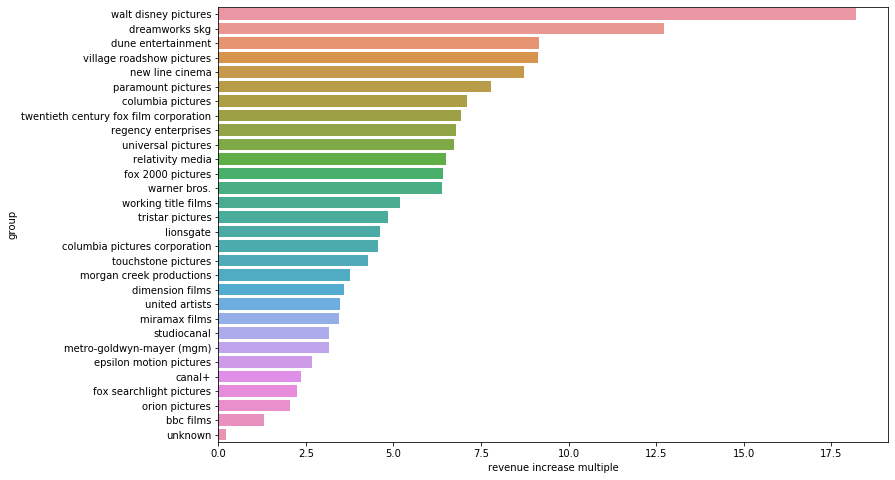

In [48]:
plt.figure(figsize=(12,8));

studio_sum = rev_summary(train, 'production_companies', 30)
sns.barplot(studio_sum['revenue']/av_revenue,'group',data=studio_sum);
plt.xlabel('revenue increase multiple');

## `production_countries`
* top countries
* number of countries per movie

In [49]:
train['production_countries'] = extract_vals(train['production_countries'],'name')
test['production_countries'] = extract_vals(test['production_countries'],'name')
get_freq(train['production_countries'])

[('united states of america', 1833),
 ('united kingdom', 301),
 ('france', 178),
 ('germany', 129),
 ('canada', 98),
 ('india', 68),
 ('italy', 53),
 ('japan', 51),
 ('australia', 47),
 ('unknown', 46),
 ('spain', 45),
 ('russia', 43),
 ('hong kong', 32),
 ('china', 28),
 ('ireland', 20),
 ('belgium', 19),
 ('south korea', 16),
 ('mexico', 16),
 ('sweden', 16),
 ('new zealand', 13),
 ('netherlands', 13),
 ('czech republic', 10),
 ('denmark', 10),
 ('luxembourg', 9),
 ('brazil', 8),
 ('hungary', 8),
 ('south africa', 7),
 ('united arab emirates', 7),
 ('romania', 6),
 ('switzerland', 6),
 ('austria', 6),
 ('israel', 5),
 ('poland', 5),
 ('finland', 5),
 ('greece', 5),
 ('chile', 5),
 ('iran', 5),
 ('norway', 4),
 ('argentina', 4),
 ('bulgaria', 3),
 ('turkey', 3),
 ('bahamas', 3),
 ('morocco', 3),
 ('pakistan', 2),
 ('ukraine', 2),
 ('singapore', 2),
 ('indonesia', 2),
 ('philippines', 2),
 ('taiwan', 2),
 ('malta', 2),
 ('qatar', 2),
 ('tunisia', 2),
 ('cambodia', 1),
 ('ethiopia', 1),

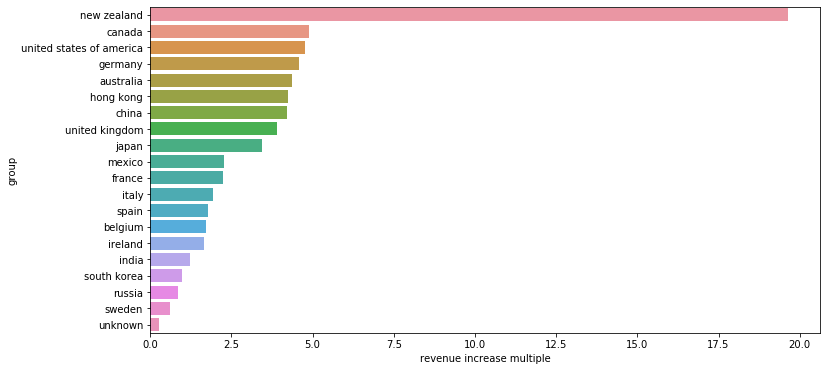

In [50]:
plt.figure(figsize=(12,6));
country_sum = rev_summary(train, 'production_countries', 20)
sns.barplot(country_sum['revenue']/av_revenue,'group', data = country_sum);
plt.xlabel('revenue increase multiple');

Movies in New Zealand appear to do really well. It turns out this is because *Lord of the Rings* movies are shot in New Zealand. New Zealand tends to be a high budget location, correlating to higher revenues. Many of the movies shot in NZ are in the 75th percentile for box office gross.

In [51]:
train[[('new zealand' in x) for x in train['production_countries']]][['title','revenue']]. \
    sort_values('revenue',ascending=False)

,title,revenue
2532,The Hobbit: An Unexpected Journey,1021103568
543,The Lord of the Rings: The Two Towers,926287400
114,The Lord of the Rings: The Fellowship of the Ring,871368364
2035,King Kong,550000000
2044,The Adventures of Tintin,371940071
1615,District 9,210819611
2730,The Piano,116700000
359,The Lovely Bones,93525586
2689,What Dreams May Come,71485043
1338,The Secret of Moonacre,7070330


Text(0, 0.5, 'log(revenue)')

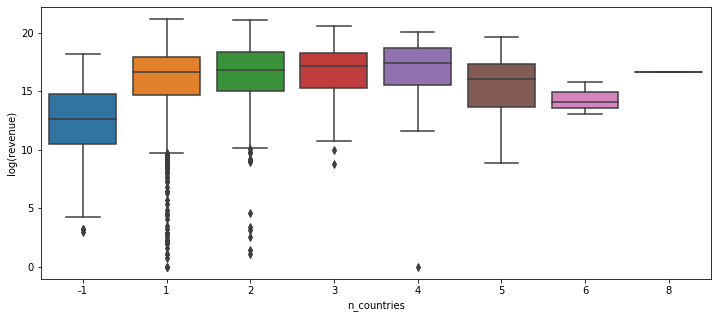

In [52]:
train['n_countries'] = count_items(train['production_countries'])
test['n_countries'] = count_items(test['production_countries'])

plt.figure(figsize=(12,5));
sns.boxplot(train['n_countries'],np.log(train['revenue']));
plt.ylabel('log(revenue)')

## `Keywords`
* top keywords
* num keywords

In [53]:
train['Keywords'] = extract_vals(train['Keywords'], 'name')
test['Keywords'] = extract_vals(test['Keywords'], 'name')

get_freq(train['Keywords'])

[('unknown', 228),
 ('woman director', 143),
 ('independent film', 128),
 ('duringcreditsstinger', 102),
 ('murder', 96),
 ('based on novel', 89),
 ('violence', 72),
 ('sport', 66),
 ('aftercreditsstinger', 61),
 ('sex', 60),
 ('biography', 60),
 ('revenge', 59),
 ('dystopia', 58),
 ('love', 56),
 ('police', 56),
 ('sequel', 55),
 ('suspense', 54),
 ('friendship', 53),
 ('teenager', 48),
 ('nudity', 48),
 ('drug', 45),
 ('female nudity', 42),
 ('prison', 40),
 ('los angeles', 39),
 ('high school', 38),
 ('musical', 38),
 ('father son relationship', 37),
 ('new york', 37),
 ('london england', 33),
 ('kidnapping', 31),
 ('detective', 31),
 ('investigation', 31),
 ('escape', 30),
 ('brother brother relationship', 30),
 ('wedding', 30),
 ('based on true story', 30),
 ('3d', 29),
 ('rape', 29),
 ('corruption', 29),
 ('paris', 29),
 ('alien', 29),
 ('family', 28),
 ('based on comic', 27),
 ('jealousy', 27),
 ('vampire', 27),
 ('soldier', 26),
 ('prostitute', 26),
 ('death', 26),
 ('robbery',

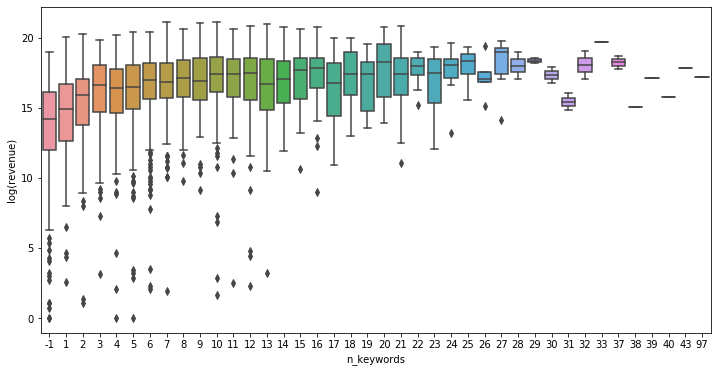

In [54]:
train['n_keywords'] = count_items(train['Keywords'])
test['n_keywords'] = count_items(test['Keywords'])

plt.figure(figsize=(12,6));
sns.boxplot('n_keywords',np.log(train['revenue']),data=train);
plt.ylabel('log(revenue)');

Movies with 20, 25, and 27 keywords seem to do especially well. Maybe I'll make a dummy variable out of those. 

## `cast`

* key actors
* cast size
* genders

In [55]:
train['cast_name'] = extract_vals(train['cast'],'name')
test['cast_name'] = extract_vals(test['cast'],'name')

get_freq(train['cast_name'])

[('j.k. simmons', 25),
 ('robert de niro', 23),
 ('susan sarandon', 22),
 ('morgan freeman', 21),
 ('john turturro', 21),
 ('forest whitaker', 20),
 ('jason statham', 20),
 ('bill murray', 20),
 ('liam neeson', 20),
 ('samuel l. jackson', 20),
 ('dennis quaid', 19),
 ('richard jenkins', 19),
 ('alec baldwin', 19),
 ('bruce willis', 19),
 ('john goodman', 18),
 ('willem dafoe', 18),
 ('nicolas cage', 18),
 ('gene hackman', 18),
 ('sigourney weaver', 18),
 ('william h. macy', 17),
 ('bruce mcgill', 17),
 ('keith david', 17),
 ('owen wilson', 17),
 ('george clooney', 17),
 ('brian cox', 16),
 ('sylvester stallone', 16),
 ('cheech marin', 16),
 ('matt damon', 16),
 ('steve buscemi', 16),
 ('denzel washington', 16),
 ('jason bateman', 16),
 ('ethan hawke', 16),
 ('mark wahlberg', 15),
 ('kevin bacon', 15),
 ('jim broadbent', 15),
 ('john c. reilly', 15),
 ('michael shannon', 15),
 ('julia roberts', 15),
 ('mel gibson', 15),
 ('john cusack', 15),
 ('michael caine', 15),
 ('robert downey jr.'

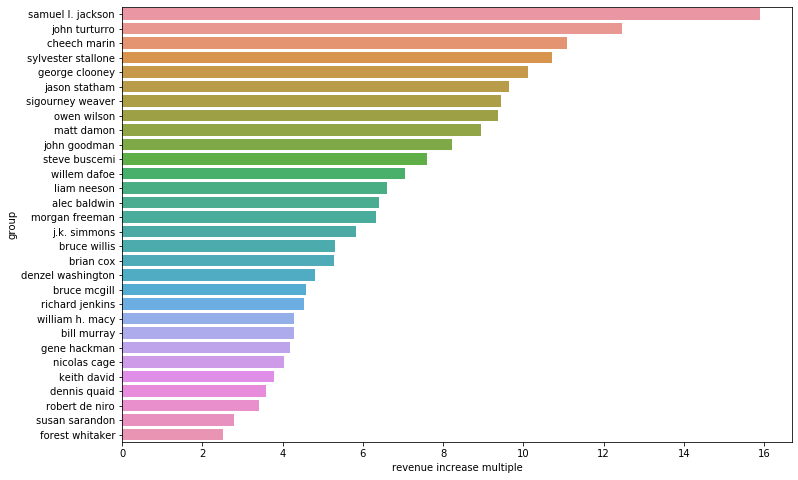

In [56]:
plt.figure(figsize=(12,8))

actor_sum = rev_summary(train,'cast_name',30)
sns.barplot(actor_sum['revenue']/av_revenue,'group',data=actor_sum);
plt.xlabel('revenue increase multiple');

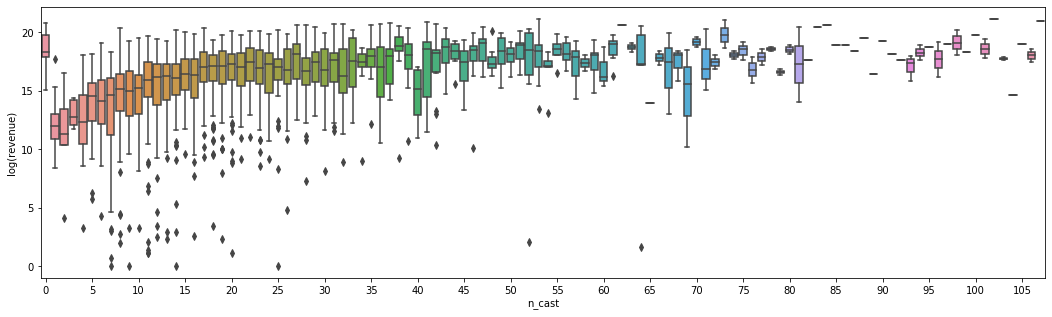

In [57]:
import matplotlib.ticker as ticker

train['n_cast'] = count_items(train['cast_name'])
test['n_cast'] = count_items(test['cast_name'])

plt.figure(figsize=(18,5))
ax = sns.boxplot(train['n_cast'],np.log(train['revenue']));
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.ylabel('log(revenue)');

In [58]:
genders_train = extract_vals(train['cast'], 'gender', fill=0)
train['n_actresses'] = [x.count(1) for x in genders_train]
train['n_actors'] = [x.count(2) for x in genders_train]

genders_test = extract_vals(test['cast'], 'gender', fill=0)
test['n_actresses'] = [x.count(1) for x in genders_test]
test['n_actors'] = [x.count(2) for x in genders_test]

0 is unknown, 1 is women, 2 is men.

## `crew`

* Departments
* Jobs
* Top names

In [59]:
train['crew_department'] = extract_vals(train['crew'],'department')
test['crew_department'] = extract_vals(test['crew'],'department')

get_freq(train['crew_department'])

[('production', 12608),
 ('sound', 7539),
 ('art', 6480),
 ('crew', 5921),
 ('writing', 5310),
 ('costume & make-up', 4911),
 ('camera', 4366),
 ('directing', 4033),
 ('editing', 3603),
 ('visual effects', 2795),
 ('lighting', 1054),
 ('unknown', 10),
 ('actors', 2)]

In [60]:
train['crew_job'] = extract_vals(train['crew'],'job')
test['crew_job'] = extract_vals(test['crew'],'job')   

get_freq(train['crew_job'])

[('producer', 4794),
 ('executive producer', 2695),
 ('director', 2604),
 ('screenplay', 2409),
 ('editor', 2277),
 ('casting', 1971),
 ('director of photography', 1818),
 ('original music composer', 1571),
 ('art direction', 1472),
 ('production design', 1325),
 ('costume design', 1264),
 ('writer', 1244),
 ('set decoration', 1083),
 ('makeup artist', 873),
 ('sound re-recording mixer', 789),
 ('camera operator', 756),
 ('script supervisor', 746),
 ('hairstylist', 628),
 ('sound effects editor', 614),
 ('visual effects supervisor', 588),
 ('still photographer', 580),
 ('music editor', 573),
 ('stunts', 558),
 ('animation', 545),
 ('dialogue editor', 529),
 ('visual effects producer', 520),
 ('music', 514),
 ('stunt coordinator', 509),
 ('supervising sound editor', 490),
 ('co-producer', 481),
 ('associate producer', 478),
 ('foley', 452),
 ('costume supervisor', 449),
 ('story', 423),
 ('set costumer', 415),
 ('sound designer', 415),
 ('gaffer', 379),
 ('novel', 374),
 ('set designer'

In [61]:
train['crew_name'] = extract_vals(train['crew'], 'name')
test['crew_name'] = extract_vals(test['crew'], 'name')

get_freq(train['crew_name'])

[('avy kaufman', 41),
 ('robert rodriguez', 35),
 ('deborah aquila', 33),
 ('jerry goldsmith', 30),
 ('luc besson', 30),
 ('james newton howard', 29),
 ('tricia wood', 29),
 ('francine maisler', 29),
 ('steven spielberg', 28),
 ('janet hirshenson', 26),
 ('kerry barden', 26),
 ('james horner', 26),
 ('mary vernieu', 26),
 ('bob weinstein', 25),
 ('jane jenkins', 25),
 ('john debney', 25),
 ('harvey weinstein', 24),
 ('clint eastwood', 24),
 ('sarah finn', 24),
 ('billy hopkins', 24),
 ('hans bjerno', 23),
 ('mark isham', 23),
 ('scott rudin', 23),
 ('alan silvestri', 22),
 ('tim bevan', 22),
 ('eric fellner', 22),
 ('arnon milchan', 22),
 ('danny elfman', 22),
 ('francis ford coppola', 21),
 ('randi hiller', 21),
 ('john papsidera', 21),
 ('bruce berman', 21),
 ('neal h. moritz', 21),
 ('thomas newman', 20),
 ('suzanne smith', 20),
 ('graeme revell', 20),
 ('mindy marin', 20),
 ('michael mann', 19),
 ('frank marshall', 19),
 ('robert zemeckis', 18),
 ('randall poster', 18),
 ('marco be

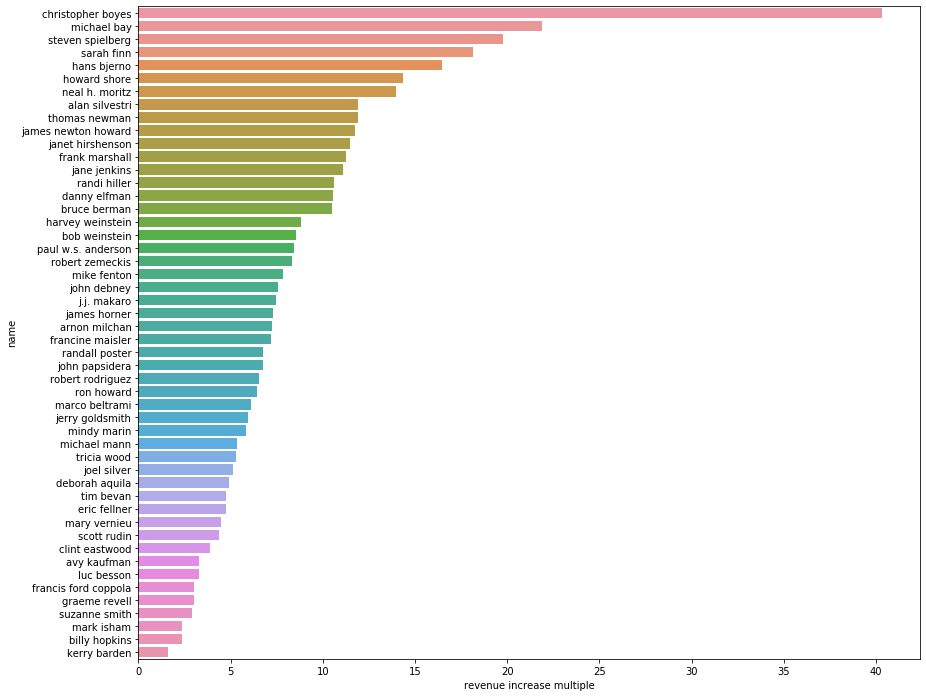

In [62]:
crew_name_sum = rev_summary(train, 'crew_name', 50)

plt.figure(figsize=(14,12))
sns.barplot(crew_name_sum['revenue']/av_revenue,'group',data=crew_name_sum);
plt.ylabel('name');
plt.xlabel('revenue increase multiple');

It's surprising is that Christopher Boyes is most dominantly associated with box office successes, moreso than Michael Bay and Steven Spielberg. On average, the movies that he's associated with earn 40x that of the average movie. Christopher Boyes is a reknowned sound engineer.

In [63]:
train['n_crew'] = count_items(train['crew_name'])
test['n_crew'] = count_items(test['crew_name'])

## `spoken_languages`

In [64]:
get_freq(extract_vals(train['spoken_languages'],'name'))

[('english', 2097),
 ('français', 220),
 ('español', 195),
 ('deutsch', 129),
 ('pусский', 116),
 ('italiano', 103),
 ('日本語', 71),
 ('普通话', 56),
 ('हिन्दी', 49),
 ('', 41),
 ('العربية', 33),
 ('português', 31),
 ('广州话 / 廣州話', 28),
 ('한국어/조선말', 28),
 ('தமிழ்', 23),
 ('polski', 21),
 ('svenska', 21),
 ('magyar', 20),
 ('latin', 20),
 ('unknown', 18),
 ('český', 17),
 ('ภาษาไทย', 15),
 ('עִבְרִית', 14),
 ('ελληνικά', 11),
 ('dansk', 9),
 ('română', 8),
 ('nederlands', 8),
 ('türkçe', 8),
 ('tiếng việt', 8),
 ('فارسی', 8),
 ('తెలుగు', 6),
 ('suomi', 6),
 ('kiswahili', 6),
 ('no language', 6),
 ('اردو', 5),
 ('український', 5),
 ('norsk', 4),
 ('ਪੰਜਾਬੀ', 3),
 ('català', 3),
 ('afrikaans', 3),
 ('gaeilge', 3),
 ('shqip', 2),
 ('somali', 2),
 ('euskera', 2),
 ('isizulu', 2),
 ('bahasa indonesia', 2),
 ('srpski', 2),
 ('íslenska', 2),
 ('বাংলা', 2),
 ('esperanto', 2),
 ('български език', 1),
 ('қазақ', 1),
 ('hrvatski', 1),
 ('wolof', 1),
 ('slovenčina', 1)]

In [65]:
train['spoken_languages'] = extract_vals(train['spoken_languages'], 'name')
test['spoken_languages'] = extract_vals(test['spoken_languages'], 'name')

## 5. Data pre-processing pipelines

In [70]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer


to_drop = ['id', 'imdb_id', 'release_date', 'revenue', 'belongs_to_collection', 
           'cast', 'crew', 'homepage', 'poster_path', 'status',
           'original_title', 'overview', 'tagline', 'title']

X_train = train.drop(to_drop,axis=1)
X_train['budget'] = X_train['budget'].astype('float')
y_train = train['revenue']

X_test = test.drop(to_drop,axis=1)
X_test['budget'] = X_test['budget'].astype('float')
y_test = test['revenue']

X_train.dtypes

budget                  float64
genres                   object
original_language        object
popularity              float64
production_companies     object
production_countries     object
runtime                 float64
spoken_languages         object
Keywords                 object
release_year              int64
release_month             int64
release_season           object
has_collection            int64
has_homepage              int64
n_genres                  int64
n_countries               int64
n_keywords                int64
cast_name                object
n_cast                    int64
n_actresses               int64
n_actors                  int64
crew_department          object
crew_job                 object
crew_name                object
n_crew                    int64
dtype: object

We're dealing with continous, discrete, and categorical variables.

### 5a. Pipeline for continuous variables

In [71]:
X_train.select_dtypes('float').head()

,budget,popularity,runtime
2545,45000000.0,14.547939,133.0
2415,0.0,10.597116,98.0
1919,0.0,4.010441,96.0
1462,8000000.0,8.172013,101.0
220,12000000.0,7.216103,132.0


In [72]:
cont_vars = list(X_train.select_dtypes(include = float).columns)

cont_pipeline = make_pipeline(
    SimpleImputer(strategy = 'median'),
    PowerTransformer(method = 'yeo-johnson', standardize = False),
    StandardScaler()
)

# test to make sure the pipeline works
pd.DataFrame(cont_pipeline.fit_transform(train[cont_vars]), columns = cont_vars);

### 5b. Pipeline for discrete variables

In [73]:
disc_vars = list(X_train.select_dtypes(include = int).columns)

disc_pipeline = make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = -1)
)

pd.DataFrame(disc_pipeline.fit_transform(train[disc_vars]), columns = disc_vars);

### 5c. Pipeline for categorical variables

* https://scikit-learn.org/dev/modules/compose.html
* https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer

In [74]:
X_train.select_dtypes(include = object)

,genres,original_language,production_companies,production_countries,spoken_languages,Keywords,release_season,cast_name,crew_department,crew_job,crew_name
2545,"[crime, drama, thriller]",en,"[cbs films, closest to the hole productions, l...","[hong kong, united states of america]","[العربية, english, 普通话]","[boston, massachusetts, police chief, terroris...",winter,"[mark wahlberg, john goodman, j.k. simmons, ke...","[lighting, lighting, directing, production, pr...","[rigging grip, rigging grip, director, produce...","[shawn s. ryder, chris ryerson, peter berg, do..."
2415,"[comedy, drama, romance]",en,"[roth-arnold productions, metro-goldwyn-mayer ...",[united states of america],"[english, português]","[brother sister relationship, autism, car garage]",spring,"[johnny depp, mary stuart masterson, aidan qui...","[directing, writing, writing, production, prod...","[director, writer, writer, producer, executive...","[jeremiah s. chechik, barry berman, lesley mcn..."
1919,"[drama, thriller]",en,[unknown],[united states of america],"[english, italiano, polski]",[post-apocalyptic],winter,"[mary mccormack, rory cochrane, tony perez, sc...","[directing, writing]","[director, author]","[chris gorak, chris gorak]"
1462,"[comedy, drama]",en,[focus features],[united states of america],[english],"[suicide, depression, independent film, coming...",summer,"[keir gilchrist, emma roberts, zach galifianak...","[art, sound, sound, writing, directing, writin...","[set decoration, supervising sound editor, sou...","[carrie stewart, paul hsu, paul hsu, ryan flec..."
220,"[drama, history, war]",other,"[media asia films, china film group corporatio...","[china, hong kong]","[english, deutsch, 日本語, 普通话]","[war crimes, mass murder, war victim, sino jap...",spring,"[liu ye, gao yuanyuan, hideo nakaizumi, john p...","[production, production, directing, writing, s...","[producer, producer, director, writer, origina...","[han sanping, john chong, lu chuan, lu chuan, ..."
378,"[animation, family, adventure]",en,"[vanguard films, scanbox]",[united kingdom],[english],"[animation, animal, 3d]",spring,"[ewan mcgregor, ricky gervais, tim curry, jim ...","[directing, writing, visual effects, writing]","[director, writer, animation, storyboard]","[gary chapman, jordan katz, michael schlingman..."
750,"[comedy, drama, romance]",en,"[fox 2000 pictures, wildgaze films, alan green...","[germany, united states of america]","[english, polski, português]","[baseball, fanatic, relationship problems, spo...",spring,"[drew barrymore, jimmy fallon, jason spevack, ...","[production, production, camera, production, w...","[producer, producer, director of photography, ...","[nancy juvonen, drew barrymore, matthew f. leo..."
2956,"[action, adventure, comedy]",en,"[cannon group, golan-globus productions]",[united states of america],"[magyar, english]","[secret passage, martial arts, gold, treasure,...",fall,"[chuck norris, louis gossett, jr., melody ande...","[editing, art, directing, production, producti...","[editor, production design, director, producer...","[richard marks, jos√© rodr√≠guez granada, j. l..."
663,"[horror, thriller]",en,"[alcon entertainment, filmnation entertainment...",[united states of america],[english],"[radiation, ukraine, nuclear radiation, touris...",spring,"[jesse mccartney, jonathan sadowski, olivia ta...","[production, crew, visual effects, art, direct...","[casting, cinematography, visual effects super...","[terri taylor, morten s√∏borg, mark o. forker,..."
2884,[comedy],en,[tristar pictures],[united states of america],"[english, deutsch]","[sex, champagne, wine, pool, undressing, waite...",spring,"[johnny depp, rob morrow, h√©ctor elizondo, an...","[directing, writing]","[director, writer]","[george bowers, gordon mitchell]"


In [75]:
X_train['original_language'].value_counts().index

Index(['en', 'other', 'fr', 'hi', 'ru', 'es'], dtype='object')

In [76]:
cat_vars = ['original_language', 'release_season']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'unknown'),
    OneHotEncoder()
)

cat_pipeline.fit_transform(train[cat_vars]);
#cat_pipeline.named_steps['onehotencoder'].get_feature_names(['original_lang','release_season']);

### 5d. Pipeline for json variables

These are all the variables originally stored in (incorrect) json format.

In [77]:
json_vars = list(set(X_train.select_dtypes(include = object).columns) - set(cat_vars))
json_vars

['cast_name',
 'spoken_languages',
 'Keywords',
 'crew_department',
 'crew_name',
 'crew_job',
 'genres',
 'production_companies',
 'production_countries']

https://stackoverflow.com/questions/4406389/if-else-in-a-list-comprehension

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

class TopCatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.top_genres = []
        self.top_spoken_languages = []
        self.top_studios = []
        self.top_keywords = []
        self.top_cast_members = []
        self.top_crew_depts = []
        self.top_crew_jobs = []
        self.top_crew_members = []
        self.top_countries = []
        
        self.feature_names = []
        
    def get_feature_names(self):
        return self.feature_names
        
        
    ## extract top names from a column of name lists 
    def _get_top_names(self, column, top_n=10):
        elements = list(chain(*column))                                     
        top_elements = [t[0] for t in Counter(elements).most_common(top_n)]     
        return top_elements  
    
    
    def _make_columns(self, column, top_names, suffix = None):
        df = pd.DataFrame()

        
        if suffix is None:
                suffix = column
                            
        for n in top_names:
                df[f"{suffix}_{n}"] = [1 if n in n_list else 0 for n_list in column]
                
        return df
    
    def fit(self,X,y=None):
        self.top_genres = self._get_top_names(X['genres'], 12)   
        self.top_spoken_languages = self._get_top_names(X['spoken_languages'], 20)
        self.top_studios = self._get_top_names(X['production_companies'], 20)
        self.top_countries = self._get_top_names(X['production_countries'], 15)
        self.top_keywords = self._get_top_names(X['Keywords'], 30)
        self.top_cast_members = self._get_top_names(X['cast_name'], 20)
        self.top_crew_depts = self._get_top_names(X['crew_department'], 20)
        self.top_crew_jobs = self._get_top_names(X['crew_job'], 20)
        self.top_crew_members = self._get_top_names(X['crew_name'], 20)
        
        return self
    
    def transform(self,X,y=None):
        
        frames = [self._make_columns(X['genres'], self.top_genres, 'genre'),
                  self._make_columns(X['spoken_languages'], self.top_spoken_languages, 'spoken_language'),
                  self._make_columns(X['production_companies'], self.top_studios, 'prod_studio'),
                  self._make_columns(X['production_countries'], self.top_countries, 'prod_country'),
                  self._make_columns(X['Keywords'], self.top_keywords, 'keyword'),
                  self._make_columns(X['cast_name'], self.top_cast_members, 'cast_member'),
                  self._make_columns(X['crew_department'], self.top_crew_depts, 'crew_dpt'),
                  self._make_columns(X['crew_job'], self.top_crew_jobs, 'crew_job'),
                  self._make_columns(X['crew_name'], self.top_crew_members, 'crew_member')]
        
        return_df = pd.concat(frames,axis=1)
        
        self.feature_names = list(return_df.columns)
        return return_df
    
json_pipeline = make_pipeline(
    TopCatEncoder()
)

json_pipeline.fit_transform(X_train[json_vars]);
json_pipeline.named_steps['topcatencoder'].get_feature_names();

### Put all processing pipelines together

In [79]:
preprocessor = ColumnTransformer(
    transformers = [
        ('continuous', cont_pipeline, cont_vars),
        ('discrete', disc_pipeline, disc_vars),
        ('categorical', cat_pipeline, cat_vars),
        ('json', json_pipeline, json_vars)
    ]
)

preprocessor.fit(X_train)

features = list(chain(cont_vars, 
                      disc_vars, 
                      cat_pipeline.named_steps['onehotencoder'].get_feature_names(['original_lang','release_season']),
                      json_pipeline.named_steps['topcatencoder'].get_feature_names()))

## 6. Model fitting pipelines

### 6.1 Shortlist some regression models

I'm going to run a bunch of regression algorithms and see which perform best out of the box.

https://stackoverflow.com/questions/33091376/python-what-is-exactly-sklearn-pipeline-pipeline

In [236]:
import warnings; warnings.simplefilter('ignore')

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoLars
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

def quick_eval(pipeline, X_train, y_train, X_test, y_test, verbose=True):
    """
    Quickly trains modeling pipeline and evaluates on test data. Returns original model, training RMSE, and testing
    RMSE as a tuple.
    """
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_score = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_score = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    if verbose:
        print(f"Regression algorithm: {pipeline.named_steps['regressor'].__class__.__name__}")
        print(f"Train RMSE: {train_score}")
        print(f"Test RMSE: {test_score}")
    
    return pipeline.named_steps['regressor'], train_score, test_score

regressors = [
    LinearRegression(),
    Lasso(alpha=.5),
    Ridge(alpha=.1),
    LassoLars(alpha=.1),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor()
]

for r in regressors:
    pipe = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', r)
    ])

    quick_eval(pipe, X_train, y_train, X_test, y_test)
    print()

Regression algorithm: LinearRegression
Train RMSE: 90680698.96219109
Test RMSE: 233337173.59506416

Regression algorithm: Lasso
Train RMSE: 90680698.6002461
Test RMSE: 233337843.81985235

Regression algorithm: Ridge
Train RMSE: 90682179.62887697
Test RMSE: 233290283.4888356

Regression algorithm: LassoLars
Train RMSE: 90680698.6003168
Test RMSE: 233337797.46264017

Regression algorithm: DecisionTreeRegressor
Train RMSE: 0.0
Test RMSE: 112298067.15162858

Regression algorithm: RandomForestRegressor
Train RMSE: 33382792.78936104
Test RMSE: 84013907.54387705

Regression algorithm: AdaBoostRegressor
Train RMSE: 111256825.70390953
Test RMSE: 118403122.15438783

Regression algorithm: GradientBoostingRegressor
Train RMSE: 45758323.39709334
Test RMSE: 80865500.98218118



For this exercise, I'll just tune the `RandomForestRegressor`.

### 6.2 Feature selection using Random Forest

#### Determine number of features _p'_ to use in final model

First, I'm going to split the data into 5 folds and get a list of feature importances for each fold.

Note: `KFold().split()` returns indices [in terms of iloc](https://stackoverflow.com/questions/52493365/indices-that-kfold-split-method-return-for-a-dataframe-is-it-iloc-or-loc
), not in terms of loc.

In [187]:
from sklearn.model_selection import KFold

# pipeline to estimate feature importances
total_features = preprocessor.fit_transform(X_train).shape[1]
rf = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(max_features=np.int(total_features/3)))
])

var_ranks = [] # feature importances for each CV split k

# get variable ranks for each fold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for tr_idx, val_idx in kf.split(X_train):
    X_train_cv, y_train_cv = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    X_val_cv, y_val_cv = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    output = quick_eval(rf, X_train_cv, y_train_cv, X_val_cv, y_val_cv, verbose=False) 
    var_ranks.append(list(output[0].feature_importances_))

/Users/collindching/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Next, I want to choose the candidates for number of features `p_hat` to feed into the final model.

In [212]:
# get candidates for number of features
def get_n_var_list(total_features, fraction, stop = 5):
    """
    fraction indicates fractional decrease in number of variables.
    """
    
    num_features = [total_features]
    while num_features[-1] > stop:
        num_features.append(int(num_features[-1] * fraction))
        
    return num_features

num_features = get_n_var_list(total_features, 2/3)
print(num_features)    

[194, 129, 86, 57, 38, 25, 16, 10, 6, 4]

Next, I want to record all CV validation set predictions for each number of features `p_hat`. I'll define `TopFeatureSelector` help me select the top `p_hat` features.

[On Python slice notation](https://stackoverflow.com/questions/509211/understanding-slice-notation).

In [213]:
from sklearn.base import BaseEstimator, TransformerMixin

# sorts by index of largest elements, argsort goes low to high
def indices_of_top_k(arr, k):
    return np.argsort(arr)[-k:]


class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
        self.feature_indices_ = []
        
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.feature_indices_]


def rf_variable_selection(X_train, y_train, num_features, kfolds = 5, repeats = 5, verbose=True):
    seeds = list(range(1,repeats+1))
    all_scores = np.empty([repeats, len(num_features)])

    for r in range(repeats):
        start = timeit.default_timer()

        # get variable ranks for each fold
        var_ranks = [] 
        kf = KFold(n_splits=5, random_state=seeds[r], shuffle=True)
        for tr_idx, val_idx in kf.split(X_train):
            X_train_cv, y_train_cv = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
            X_val_cv, y_val_cv = X_train.iloc[val_idx], y_train.iloc[val_idx]
            output = quick_eval(rf, X_train_cv, y_train_cv, X_val_cv, y_val_cv, verbose=False) 
            var_ranks.append(list(output[0].feature_importances_))


        for c in range(len(num_features)):
            p_hat = num_features[c]
            p_hat_scores = []

            # get test scores for each fold
            for fold, idxs in enumerate(kf.split(X_train)):            
                selector_pipeline = Pipeline(steps = [
                    ('preprocessor', preprocessor),
                    ('selector', TopFeatureSelector(var_ranks[fold], p_hat)),
                    ('regressor', RandomForestRegressor(n_estimators=50,max_features=int(p_hat/3)))
                ])

                tr_idx, val_idx = idxs[0], idxs[1]

                X_train_cv, y_train_cv = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
                X_val_cv, y_val_cv = X_train.iloc[val_idx], y_train.iloc[val_idx]

                output = quick_eval(selector_pipeline, X_train_cv, y_train_cv, X_val_cv, y_val_cv, verbose=False) 
                val_rmse = output[2]
                p_hat_scores.append(val_rmse) 

            all_scores[r,c] = np.mean(p_hat_scores)

        stop = timeit.default_timer()
        
        if verbose:
            print('Repeat time: ', stop - start)  
        
    result = pd.melt(pd.DataFrame(all_scores, columns=num_features),var_name='p_hat',value_name='rmse')
    return result

p_hat_results = rf_variable_selection(X_train, y_train, num_features, kfolds=5, repeats = 10)

Repeat time:  57.420981105002284
Repeat time:  56.86881867299962
Repeat time:  56.96804855099981
Repeat time:  56.75918830199953
Repeat time:  56.512527702001535
Repeat time:  56.66934322000088
Repeat time:  56.803107562998775
Repeat time:  58.68824836600106
Repeat time:  64.01509715200154
Repeat time:  60.00627754599918


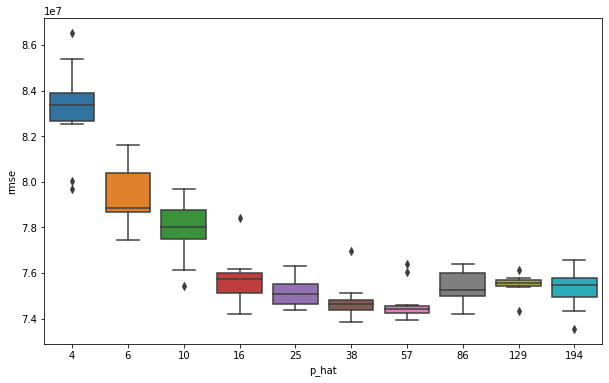

In [221]:
plt.figure(figsize=(10,6))
sns.boxplot('p_hat', 'rmse', data=p_hat_results);
plt.ylabel('mean rmse')

You can see that after 57 features in the model, having more features doesn't do much for our average mse. Reducing features will not only improve model performance, but also interpretability. Based on this chart, I'll use 57 predictors in my final model.

### 6.3 Tune Random Forest 

Skipping this step

* https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
* https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

In [327]:
# from sklearn.model_selection import GridSearchCV

# rf.fit(X_train, y_train)
# feature_importances = rf.named_steps['regressor'].feature_importances_

# selector_pipeline = Pipeline(steps = [
#                     ('preprocessor', preprocessor),
#                     ('selector', TopFeatureSelector(feature_importances, 57)),
#                     ('regressor', RandomForestRegressor(n_estimators=200))
#                 ])


# param_grid = {
#     'regressor__max_features': [20, 30, 40, 50],
#     'regressor__max_depth': [20, 30, 40],
#     'regressor__min_samples_split': [.05, .075, .1],
#     'regressor__min_samples_leaf': [.05, .075, .1],
# }

# gridsearch = GridSearchCV(selector_pipeline, 
#                           param_grid, 
#                           scoring = 
#                           'neg_mean_squared_error', 
#                           cv = 5, 
#                           n_jobs = 4, 
#                           verbose = True)

# gridsearch.fit(X_train, y_train);

# print(f"The best estimator had RMSE {np.sqrt(-gridsearch.best_score_)} and the following parameters:")
# print(gridsearch.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  3.4min finished


### 6.4 Compare performance

This is a quick sanity check to make sure that our choice of `p_hat` is justified. We compare model performance using all features to model performance using just 57 features.

In [317]:
# 194 features
pipe1 = Pipeline(steps = [
                    ('preprocessor', preprocessor),
                    ('regressor', RandomForestRegressor(n_estimators=200,max_features=20))
                ])

quick_eval(pipe1, X_train, y_train, X_test, y_test);

Regression algorithm: RandomForestRegressor
Train RMSE: 28372508.526909105
Test RMSE: 85563001.97383349


In [316]:
# 57 features
pipe2 = Pipeline(steps = [
                    ('preprocessor', preprocessor),
                    ('selector', TopFeatureSelector(feature_importances,57)),
                    ('regressor', RandomForestRegressor(n_estimators=200,max_features=20))
                ])
quick_eval(pipe2, X_train, y_train, X_test, y_test);

Regression algorithm: RandomForestRegressor
Train RMSE: 27724591.63292086
Test RMSE: 79698047.57052584


Using 57 features (as opposed to 194) results in a small decrease in rmse and improves model interpretability. This is our final model!

### 6.5 Feature importances with random forest

In [319]:
final_model.named_steps['selector'].feature_indices_

array([ 43, 170, 156, 121, 173,  76,  60, 147,  27,  20, 155,  22, 118,
       188, 162,  32,  29,  36, 161,  77, 166,  59, 189,  21, 187,  25,
        33,  24, 183,  83,  28,  65,  57,  34, 168, 171, 152,   6,   8,
        99, 182, 172,   7,   3,   9,   4, 130,  11,  10, 150,   2,  30,
         5,  12,  13,   1,   0])

In [303]:
def get_feature_importances(features, feature_importances, desc = True):
    return sorted(zip(features, feature_importances), reverse = desc, key = lambda x: x[1])
    
def plot_feature_importances(features, feature_importances, desc = True, top_n = 10):
    feat_df = pd.DataFrame(sorted(zip(features, feature_importances), reverse = desc, key = lambda x: x[1]),
                          columns = ['feature', 'feature_importance'])
    
    return sns.barplot('feature_importance', 'feature', data = feat_df.iloc[:top_n]) 

final_model = pipe2
final_feature_names = pd.Series(features)[final_model.named_steps['selector'].feature_indices_]
final_feature_importances = final_model.named_steps['regressor'].feature_importances_
get_feature_importances(final_features, final_feature_importances);

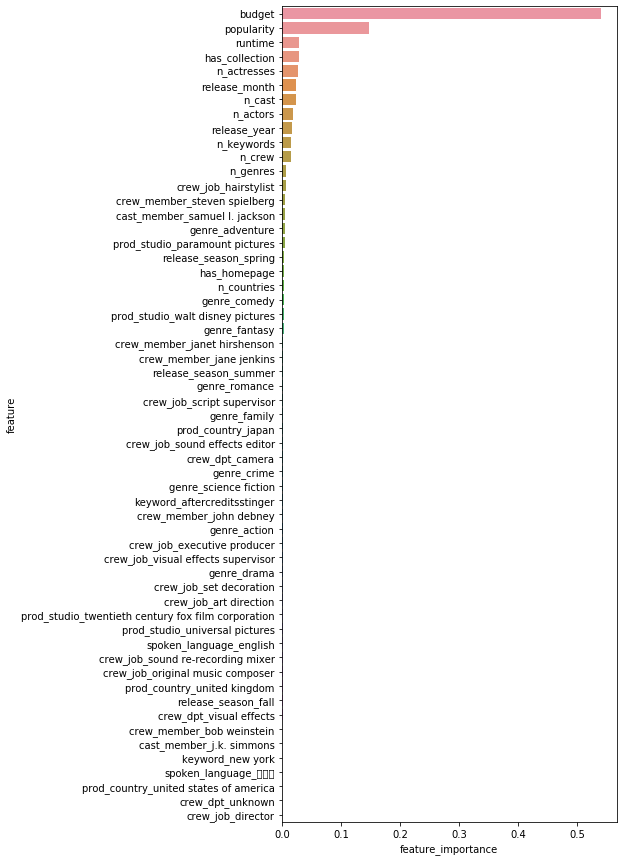

In [315]:
plt.figure(figsize = (6, 15))
plot_feature_importances(final_features, final_feature_importances, top_n=57);

Based on the feature importances here, the most crucial features to determining box office success are budget and popularity. If a movie is part of a collection or series of movies, it generally tends to perform better than movies that aren't part of a collection. Number of actors and actresses are both important, and time of release is also important.

## 7. Next steps

If I were to continue on with this project, some strategies I would use to improve model performance would be to process text features (`tagline`, `overview`) with NLP, do some feature engineering, add in external data (content rating, number of votes, actor ratings), and tune the final model. 